A Python script to visualize the weather of 500+ cities across the world of varying distance from the equator.


![title](equatorsign.png)

# WeatherPy
----

### Our Dataset:

----

The range of latitudes for the cities is -55 to +79. Most of the cities fall between latitudes of -30 to +50. Since the northern hemisphere has a lot more land than the southern hemisphere, we can expect to have more cities in the Northern Hemisphere. In fact, about 90 percent of the world's people live in the Northern Hemisphere.

----

### Analysis

----

* The Southern Hemisphere is currently tilted towards the sun and is therefore warmer than the Northern Hemisphere. From the above scatter plot you see that the weather gets warmer as it approaches the equator (0 Deg. Latitude) and then as we move North away from the equator, it gets colder at a faster rate. If we ran this analysis in September, the plot would probably be a mirror image of this one.

* Humidity does not seem to be related to the Latitude. It may relate to the proximity of the city to water bodies. There seems to be a strong band of cities with 100% humidity.

* There seems to be no relation between Latitude and Cloudiness. There is a strong band of cities with 0% cloudiness.
* Latitude and wind speed do not seem to be related. But the city with the highest wind speed is in the Northern Hemisphere.

----


In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import openweathermapy.core as owm

# Import API key
import keys.api_keys as key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city.title())

# Print the city count to confirm sufficient count
len(cities)

1500

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:

# Create settings dictionary with information we're interested in
f = open('output/MissingCitiesInOWM.txt','w')
settings = {"units": "metric", "appid": key.api_key}
def getWeather(city):
    weather = np.nan
    try:
        weather = owm.get_current(city, **settings)
    except Exception as e:
        f.write("Weather Data missing for {} : {}\n".format(city, e))
    return weather

In [4]:
# Create a Pandas DataFrame with the results
df = pd.DataFrame({"City":cities})
df["weather_data"] = df["City"].map(getWeather)
f.close()
df.count()

City            1500
weather_data    1367
dtype: int64

In [5]:
# Drop all rows with cities that have no weather data
df = df.dropna(how="any")
df.count()

City            1367
weather_data    1367
dtype: int64

In [6]:
# Extract the temperature, latitude and longitude in each city
df["Latitude"] = df["weather_data"].map(lambda weather:weather("coord.lat"))
df["Longitude"] = df["weather_data"].map(lambda weather:weather("coord.lon"))
df["Temparature"] = df["weather_data"].map(lambda weather:weather("main.temp"))
df["Humidity"] = df["weather_data"].map(lambda weather:weather("main.humidity"))
df["Cloudiness"] = df["weather_data"].map(lambda weather:weather("clouds.all"))
df["Wind Speed"] = df["weather_data"].map(lambda weather:weather("wind.speed"))
df["Current Weather"] = df["weather_data"].map(lambda weather:weather("weather")[0].get("description"))
df["Country"] = df["weather_data"].map(lambda weather:weather("sys.country"))

# delete the weather data object since we have now extracted all the required data
del(df["weather_data"])
df = df[["City", "Country", "Latitude", "Longitude", "Temparature",\
         "Humidity", "Cloudiness", "Wind Speed","Current Weather"]]


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [7]:
df.to_csv("cityWeather.csv")

In [8]:
!open "cityWeather.csv"

In [9]:
df.head()

,City,Country,Latitude,Longitude,Temparature,Humidity,Cloudiness,Wind Speed,Current Weather
0,Waitara,NZ,-39.00,174.24,21.67,52,92,3.13,light rain
1,Dikson,RU,73.51,80.55,-21.00,82,36,12.70,scattered clouds
2,Hilo,US,19.71,-155.08,23.41,44,75,3.10,broken clouds
3,San Antonio,CL,-33.58,-71.61,16.55,77,0,3.10,clear sky
4,Port Alfred,ZA,-33.59,26.89,17.48,71,12,3.13,few clouds


# How does our dataset look like?

In [10]:
df.describe()

,Latitude,Longitude,Temparature,Humidity,Cloudiness,Wind Speed
count,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000
mean,8.363431,1.977791,10.820629,71.604243,37.329188,4.621895
std,39.878110,98.403533,14.980209,19.808581,34.562777,3.342072
min,-54.810000,-179.170000,-40.100000,8.000000,0.000000,0.250000
25%,-30.970000,-73.750000,1.565000,55.000000,0.000000,2.100000
50%,8.960000,3.910000,14.030000,73.000000,36.000000,4.100000
75%,42.650000,87.705000,23.410000,86.000000,75.000000,6.690000
max,78.220000,179.320000,33.940000,100.000000,100.000000,24.200000


The range of latitudes for the cities is -55 to +79. Most of the cities fall between latitudes of -30 to +50.
Since the northern hemisphere has a lot more land than the southern hemisphere, we can expect to have more cities in the Northern Hemisphere.
In fact, about 90 percent of the world's people live in the Northern Hemisphere. 

In [11]:
cities_n = df["City"][df["Latitude"]>=0].count()
cities_s = df["City"][df["Latitude"]<0].count()
total = df["City"].count()
dataset_df = pd.DataFrame({"Region":["Northern Hemisphere","Southern Hemisphere","World"],
              "Counts":[cities_n, cities_s, total]}).set_index("Region")
dataset_df["%Counts"] = (100 * dataset_df["Counts"]/total).round(2)
dataset_df

,Counts,%Counts
Region,,
Northern Hemisphere,757,55.38
Southern Hemisphere,610,44.62
World,1367,100.00


As you see from the above numbers, the distribution of the cities in terms of latitude is good.

### Plotting the Data

In [12]:
today = pd.to_datetime('today').date()
print(today)

2019-02-26


#### Latitude vs. Temperature Plot

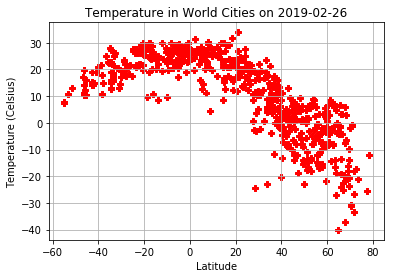

In [13]:
# Build a scatter plot for each data type
plt.scatter(df["Latitude"], df["Temparature"], marker="P", c='r')

# Incorporate the other graph properties
plt.title("Temperature in World Cities on {}".format(today))
plt.ylabel("Temperature (Celsius)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("output/TemperatureInWorldCities-{}.png".format(today))

# Show plot
plt.show()

The Southern Hemisphere is currently tilted towards the sun and is therefore warmer than the Northern Hemisphere. 
From the above scatter plot you see that the weather gets warmer as it approaches the equator (0 Deg. Latitude) 
and then as we move North away from the equator, it gets colder at a faster rate.

If we ran this analysis in September, the plot would probably be a mirror image of this one. 

#### Latitude vs. Humidity Plot

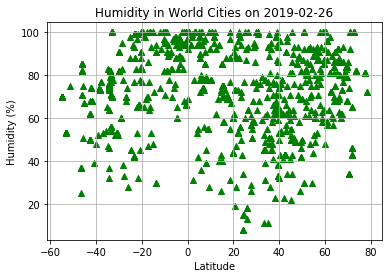

In [14]:
# Build a scatter plot for each data type
plt.scatter(df["Latitude"], df["Humidity"], marker="^", c = 'g')

# Incorporate the other graph properties
plt.title("Humidity in World Cities on {}".format(today))
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("output/HumidityInWorldCities-{}.png".format(today))

# Show plot
plt.show()

Humidity does not seem to be related to the Latitude. It may relate to the proximity of the city to water bodies. 
There seems to be a strong band of cities with 100% humidity.

#### Latitude vs. Cloudiness Plot

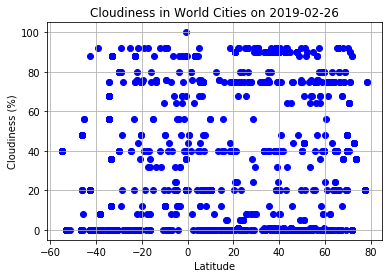

In [15]:
# Build a scatter plot for each data type
plt.scatter(df["Latitude"], df["Cloudiness"], marker="o", c = 'b')

# Incorporate the other graph properties
plt.title("Cloudiness in World Cities on {}".format(today))
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("output/CloudinessInWorldCities-{}.png".format(today))
# Show plot
plt.show()

There seems to be no relation between Latitude and Cloudiness. There is a strong band of cities with 0% cloudiness.

#### Latitude vs. Wind Speed Plot

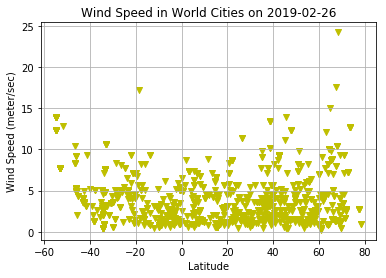

In [16]:
# Build a scatter plot for each data type
plt.scatter(df["Latitude"], df["Wind Speed"], marker="v", c = 'y')

# Incorporate the other graph properties
plt.title("Wind Speed in World Cities on {}".format(today))
plt.ylabel("Wind Speed (meter/sec)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("output/WindSpeedInWorldCities-{}.png".format(today))

# Show plot
plt.show()

Latitude and wind speed do not seem to be related. But the city with the highest wind speed is in the 
Northern Hemisphere.
